# Set up

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.nn.utils.rnn import *
import gtn
import soundfile as sf
from IPython.display import display, Image

In [2]:
etc_path = "/home/ubuntu/project/an4/etc/"
wav_path = "/home/ubuntu/project/an4/wav/"

In [3]:
train_fileids_path = etc_path + "an4_train.fileids"
train_trans_path = etc_path + "an4_train.transcription"

test_fileids_path = etc_path + "an4_test.fileids"
test_trans_path = etc_path + "an4_test.transcription"

phones_path = etc_path + "an4.phone"
filler_path = etc_path + "an4.filler"
dict_path = etc_path + "an4.dic"

In [4]:
with open(phones_path, 'r') as f:
    phones = f.read().splitlines()

print(phones)
print(len(phones))
phones_plus_one = ['#'] + phones
label_to_phone = dict(enumerate(phones_plus_one))

['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'OW', 'P', 'R', 'S', 'SIL', 'T', 'TH', 'UW', 'V', 'W', 'Y', 'Z']
34


In [5]:
num_phones = len(phones_plus_one)
print(num_phones)

35


In [6]:
word_to_phones = {}
phones_to_words = {}

for d in [dict_path, filler_path]:
    with open(d, 'r') as f:
        mappings = f.read().splitlines()
        for pair in mappings:
            items = pair.split()
            word = items[0]
            transc = tuple(phones.index(i)+1 for i in items[1:])

            if word.endswith(")"):
                word = word[:-3]
                word_to_phones[word].append(transc)
            else:
                word_to_phones[word] = [transc]

            if transc not in phones_to_words:
                phones_to_words[transc] = []
            phones_to_words[transc].append(word)
    
# print(word_to_phones) # 0 is the blank index (not silence!)
# print(phones_to_words) #need to use a tuple as an index
# these do not contain <s> and </s> which are considered words

In [7]:
# word_graphs = {}
def make_word_graph(word, calc_grad=True, blank=0):
#     if word in word_graphs:
#         return word_graphs[word]
    
    pron = word_to_phones[word]
    G = None
    for pidx in range(len(pron)):
        pronunciation = pron[pidx]
        g = gtn.Graph(calc_grad)
        u = len(pronunciation) * 2 + 1
        for l in range(u):
            idx = (l-1) // 2
            is_start = (l == 0)
            is_accept = (l == u-1) or (l == u-2)
            g.add_node(is_start, is_accept)
            label = pronunciation[idx] if l % 2 else blank
            g.add_arc(l, l, label, label)
            if l > 0:
                g.add_arc(l-1, l, label, label)
            if (l % 2) and (l > 1) and label != pronunciation[idx-1]: # not a repetition
                g.add_arc(l-2, l, label, label)
        
        if pidx == 0:
            G = g
        else:
            G = gtn.union((G, g))
#     word_graphs[word] = G
    return G


In [8]:
# a_word = make_word_graph('A', True, 0)
# # sil_word = make_word_graph('<sil>', True, 0)
# # h_word = make_word_graph('H', True, 0)
# gtn.draw(a_word, "a_word.png", label_to_phone, label_to_phone)
# display(Image("a_word.png"))
# # print(seventeen.weights_to_list())

# emit = gtn.linear_graph(5, num_phones, calc_grad=True)
# emit.set_weights(list(range(175))) # set in the same order as the phoneme order
# gtn.draw(emit, "emit.png", label_to_phone, label_to_phone)
# display(Image("emit.png"))
# # print(len(emit.weights_to_list()))

# # # combined_word = gtn.concat((a_word, sil_word, h_word))
# alignment = gtn.compose(a_word, emit)
# gtn.draw(alignment, "a_align.png", label_to_phone, label_to_phone)
# display(Image("a_align.png"))

# intersection = gtn.intersect(a_word, emit)
# gtn.draw(intersection, "a_is.png", label_to_phone, label_to_phone)
# display(Image("a_is.png"))

In [9]:
# print(word_graphs)

In [10]:
# for word in word_to_phones:
#     make_word_graph(word, True, 0)

In [11]:
with open(test_trans_path, 'r') as f:
    transc = f.read().splitlines()
    for line in transc:
        print(line.split()[:-1])

['RUBOUT', 'G', 'M', 'E', 'F', 'THREE', 'NINE']
['ERASE', 'C', 'Q', 'Q', 'F', 'SEVEN']
['B', 'A', 'O', 'Z', 'FIVE', 'THREE']
['GO']
['RUBOUT', 'N', 'I', 'M', 'N', 'ONE']
['W', 'O', 'O', 'D']
['C', 'I', 'N', 'D', 'Y']
['ONE', 'THREE', 'SEVEN']
['M', 'E', 'L', 'V', 'I', 'N']
['P', 'L', 'E', 'A', 'S', 'A', 'N', 'T', 'H', 'I', 'L', 'L', 'S']
['ONE', 'FIVE', 'TWO', 'THREE', 'SIX']
['SIX', 'FIVE', 'FIVE', 'EIGHT', 'SEVEN', 'FOUR', 'ZERO']
['ELEVEN', 'TWENTY', 'SEVEN', 'FIFTY', 'SEVEN']
['NO']
['ENTER', 'NINE', 'ONE', 'SIX', 'NINE']
['ENTER', 'EIGHT', 'NINETY', 'SEVEN']
['J', 'P', 'E', 'G', 'FOUR']
['ERASE', 'X', 'A', 'G', 'N', 'A', 'SIX', 'THIRTY', 'FIVE']
['P', 'A', 'T', 'T', 'E', 'R', 'S', 'O', 'N']
['J', 'A', 'N', 'E', 'T']
['ONE', 'FIFTY']
['S', 'P', 'E', 'E', 'R']
['M', 'C', 'K', 'E', 'E', 'S', 'R', 'O', 'C', 'K', 'S']
['ONE', 'FIVE', 'ONE', 'THREE', 'SIX']
['THREE', 'THREE', 'ONE', 'OH', 'ONE', 'EIGHT', 'EIGHT']
['TWELVE', 'TWENTY', 'NINE', 'FIFTY', 'NINE']
['ENTER', 'NINE', 'TWO', 'EI

In [12]:
def make_sent_graph(word_list, calc_grad=True, blank=0):
    interleaved_list = ['<s>']
    for word in word_list:
        interleaved_list.append(word)
        interleaved_list.append('<sil>')
    interleaved_list = interleaved_list[:-1]
    interleaved_list.append('</s>')
    graphs = [make_word_graph(wrd, calc_grad, blank) for wrd in interleaved_list]
    return gtn.concat(graphs)

# Dataset

In [13]:
kernel_size = 100
stride = 50
padding = 0

def get_conv_out_size(in_len):
    return ((in_len - kernel_size) // stride) + 1

In [14]:
class MyDataset(Dataset):
    def __init__(self, fileids_path, trans_path, end_marked=False):
        super().__init__()
        
        with open(fileids_path, 'r') as f:
            self.audio_files = f.read().splitlines()
        with open(trans_path, 'r') as f:
            transc = f.read().splitlines()   
            self.trans_graphs = []
            for line in transc:
                # make the corresponding graph
                transcription = line.split()[:-1]
                if end_marked:
                    transcription = transcription[1:-1]
                self.trans_graphs.append(make_sent_graph(transcription))
        self.len = len(self.audio_files)
        assert(self.len == len(self.trans_graphs))
        
    def __len__(self):
        return self.len

    def __getitem__(self, ind):
        full_audio_path = wav_path + self.audio_files[ind] + ".sph"
        audio_tensor = torch.FloatTensor(sf.read(full_audio_path)[0]).unsqueeze(1)
        audio_tensor_len = get_conv_out_size(audio_tensor.shape[0])
#         print(audio_tensor.shape, audio_tensor_len)
        return audio_tensor, audio_tensor_len, ind


In [15]:
train_dataset = MyDataset(train_fileids_path, train_trans_path, True)

In [16]:
# g1 = (train_dataset.trans_graphs[0])
# gtn.draw(g1, "g1.png", label_to_phone, label_to_phone)
# display(Image("g1.png"))

In [17]:
cuda = torch.cuda.is_available()
print(cuda)
num_workers = 8 if cuda else 0

True


In [18]:
class MyBatch:
    def __init__(self, data):
        zipped = list(zip(*data))
#         print([i.shape for i in zipped[0]])
#         print([a.shape for a in zipped[0]])
        self.X = pad_sequence(zipped[0])
#         print(self.X.shape, [a.shape for a in zipped[0]])
        self.X_len = torch.LongTensor(zipped[1])
#         self.Y = pad_sequence(zipped[2], batch_first=True)
#         self.Y_len = torch.LongTensor(zipped[3])
        self.Y = torch.LongTensor(zipped[2])

    def pin_memory(self):
        self.X = self.X.pin_memory()
        self.X_len = self.X_len.pin_memory()
        self.Y = self.Y.pin_memory()
        return self

def collate_wrapper(batch):
    return MyBatch(batch)

In [19]:
train_loader_args = dict(shuffle=True, batch_size=20,
                            num_workers=num_workers, pin_memory=False, drop_last=True, collate_fn=collate_wrapper) if cuda\
                    else dict(shuffle=True, batch_size=20, collate_fn=collate_wrapper)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

In [20]:
test_dataset = MyDataset(test_fileids_path, test_trans_path, True)
test_loader_args = dict(shuffle=True, batch_size=20,
                            num_workers=num_workers, pin_memory=False, drop_last=True, collate_fn=collate_wrapper) if cuda\
                    else dict(shuffle=True, batch_size=20, collate_fn=collate_wrapper)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

# Model

In [21]:
class Model(nn.Module):
    def __init__(self, in_vocab, out_vocab, embed_size, hidden_size):
        super(Model, self).__init__()
#         self.embed = nn.Embedding(in_vocab, embed_size)
        self.cnn = nn.Conv1d(1, 5, kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm1d(5)
        self.relu = F.relu

        self.lstm = nn.LSTM(5, hidden_size, num_layers=2, bidirectional=True, batch_first=False)
        self.output = nn.Linear(hidden_size*2, out_vocab)
    
    def forward(self, X, lengths):
#         X = self.embed(X)
#         print(X.shape)
        X_t = X.permute(1,2,0)
#         print(X_t.shape)
        cnn_xt = self.cnn(X_t)
        cnn_xt = self.bn(cnn_xt)
        cnn_xt = self.relu(cnn_xt)
#         print(cnn_xt.shape)
        cnn_x = cnn_xt.permute(2,0,1)
#         print(cnn_x.shape)
#         print(cnn_x)
        
        packed_X = pack_padded_sequence(cnn_x, lengths, enforce_sorted=False)
        packed_out = self.lstm(packed_X)[0]
        out, out_lens = pad_packed_sequence(packed_out)
        out = self.output(out).log_softmax(2)
        return out, out_lens

In [22]:
test1 = torch.arange(0,30).reshape(5,2,3)
print(test1)
testweight = test1[:4, 0, :].flatten()
print(testweight)

test2 = torch.ones(2,3)
test1[:2, 0, :] = test2
print(test1)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23]],

        [[24, 25, 26],
         [27, 28, 29]]])
tensor([ 0,  1,  2,  6,  7,  8, 12, 13, 14, 18, 19, 20])
tensor([[[ 1,  1,  1],
         [ 3,  4,  5]],

        [[ 1,  1,  1],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23]],

        [[24, 25, 26],
         [27, 28, 29]]])


In [23]:
# def indiv_ctc_loss(weights, ind):
#     T = weights.shape[0]
#     flat_weights = weights.flatten()

#     emit = gtn.linear_graph(T, num_phones, calc_grad=True)
#     emit.set_weights(flat_weights) # set in the same order as the phoneme order

#     constraint = train_dataset.trans_graph[ind]
# #     print(type(constraint))
    
#     alignment = gtn.compose(constraint, emit)
#     ctc_loss = gtn.negate(gtn.forward_score(alignment))
#     gtn.backward(ctc_loss)

In [86]:
class GTNLossFunction(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, inputs, input_lengths, targets): #targets is index in trans_graph
        _, B, _ = inputs.shape
        losses = [None] * B
        emissions_graphs = [None] * B
#         print('forward')
    
        def forward_single(b):
            T = input_lengths[b]
            weights = inputs[:T, b, :].flatten().contiguous()
            flat_weights = weights.data_ptr()
            
            ind = targets[b]

            emit = gtn.linear_graph(T, num_phones, inputs.requires_grad)
#             print(type(flat_weights))
            emit.set_weights(flat_weights) # set in the same order as the phoneme order

            constraint = train_dataset.trans_graphs[ind]
#             print(constraint.grad())

            alignment = gtn.compose(constraint, emit)
            ctc_loss = gtn.negate(gtn.forward_score(alignment))

            losses[b] = ctc_loss
            emissions_graphs[b] = emit


        # Compute the loss in parallel over the batch:
        gtn.parallel_for(forward_single, range(B))

        ctx.auxiliary_data = (losses, emissions_graphs, inputs.shape, input_lengths, targets)
        
        # assert False
        # Put losses back in a torch tensor and move them  back to the device:
        return torch.tensor([l.item() for l in losses])


    @staticmethod
    def backward(ctx, grad_output, retain_graph=True):
#         print("backward")
        losses, emissions_graphs, in_shape, input_lengths, targets = ctx.auxiliary_data
        T, B, C = in_shape
        input_grad = torch.empty((T, B, C))

        # Compute the gradients for each example:
        def backward_single(b):
#             print(losses[b])
#             print(dir(losses[b]))
#             print(b)
            gtn.backward(losses[b], retain_graph=retain_graph)
            emissions = emissions_graphs[b]
            grad = emissions.grad().weights_to_numpy()
            print(grad)
#             print(input_lengths[b].detach())
            input_grad[:int(input_lengths[b].detach()),b,:] = torch.from_numpy(grad).view(
                                                                int(input_lengths[b].detach()), C)
#             print(input_grad[b].shape, input_lengths[b])
#             emissions.zero_grad()
#             losses[b].zero_grad()
#             print(train_dataset.trans_graphs[targets[b]].grad().weights_to_numpy())
            train_dataset.trans_graphs[targets[b]].zero_grad()


        # Compute gradients in parallel over the batch:
        gtn.parallel_for(backward_single, range(B))
        # for b in range(B):
        #     print(b)
        #     backward_single(b)

        return input_grad, None, None

# make an alias for the loss function:
GTNLoss = GTNLossFunction.apply

# Training Utilities

In [87]:
import time

def train_epoch(model, train_loader, criterion, optimizer):

    model.train()
    
    running_loss = 0.0
    start_time = time.time()
    for batch_ids, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = batch.X.to(device)
        x_len = batch.X_len.to(device)
        y = batch.Y
        out, out_lens = model(x, x_len)
        out = out.to("cpu")
        out_lens = out_lens.to("cpu")
        loss = criterion(out, out_lens, y).mean()
        print("batch:", batch_ids, "loss", loss.item())
        running_loss += loss.item()
        loss.backward(retain_graph=False)

        optimizer.step()
        
    end_time = time.time()
    
    running_loss /= len(train_loader)
    
    print("Training Loss: ", running_loss, "Time: ", end_time - start_time, "s")
    return running_loss

In [88]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        
        running_loss = 0.0
        
        for batch_idx, batch in enumerate(test_loader):
            X = batch.X.to(device)
            X_len = batch.X_len.to(device)
            Y = batch.Y
            
            out, out_lens = model(X, X_len)
            out = out.to("cpu")
            out_lens = out_lens.to("cpu")

            loss = criterion(out, out_lens, Y).mean()
            running_loss += loss.item()
            
        running_loss /= len(test_loader)
        print("Testing Loss: ", running_loss)
        return running_loss

In [89]:
torch.manual_seed(11785)
model = Model(40, num_phones, 5, 50)
criterion = GTNLoss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
torch.autograd.set_detect_anomaly(True)

device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

Model(
  (cnn): Conv1d(1, 5, kernel_size=(100,), stride=(50,))
  (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(5, 50, num_layers=2, bidirectional=True)
  (output): Linear(in_features=100, out_features=35, bias=True)
)


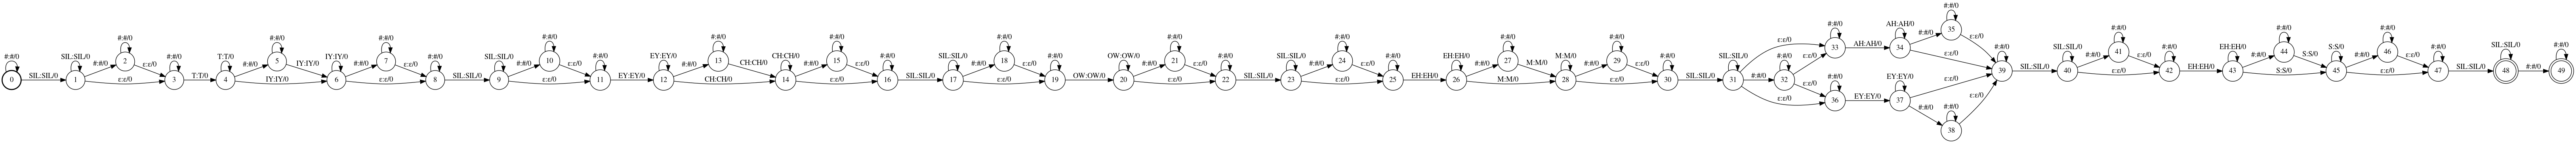

KeyboardInterrupt: 

In [90]:
num_epochs = 5
training_losses = []
testing_losses = []

for i in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
               }, "Model_"+str(i))
    
    test_loss = test_model(model, test_loader, criterion)
    training_losses.append(train_loss)
    testing_losses.append(test_loss)
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(name, param.data)
    print("=====End of Epoch", i, "=====")